1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


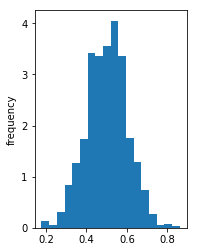

In [56]:
import numpy as np
import matplotlib.pyplot as plt

mu, sigma = 0.5, 0.1
a=np.random.normal(loc=mu,scale=sigma,size=1000)
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.hist(a, bins=18,density=True)
plt.ylabel('frequency')
plt.yticks(np.arange(0, 5, step=1))
plt.show()
m=1.06*a.std()*a.size**(-1/5)
ax2=fig.add_subplot(122)

    

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

In [ ]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')


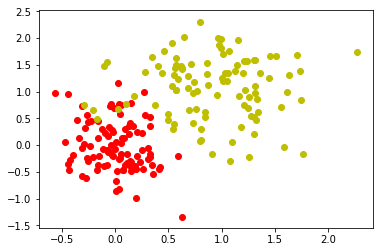

In [50]:
u=0
std=0.25
u1=1
std1=0.5
X=np.random.normal(u,std,100)
Y=np.random.normal(u,std1,100)

X1=np.random.normal(u1,std1,100)
Y1=np.random.normal(u1,std1,100)
plt.scatter(X,Y, marker='o', c='r')
plt.scatter(X1,Y1,marker='o', c='y')
plt.show()

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should you the `np.load()` function to load the file as a numpy array and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

C:\Users\Mouna\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


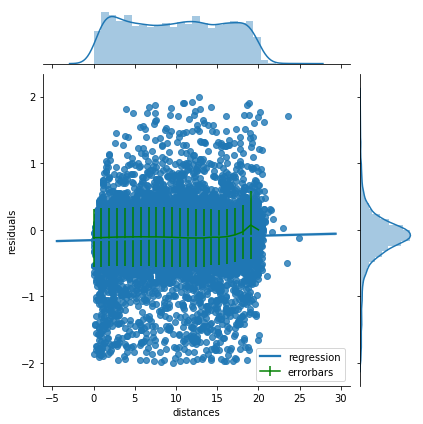

In [49]:
import pandas as pd
import scipy.stats as sp
import seaborn as sb
%matplotlib inline
d=np.load('residuals_261.npy').item()
df = pd.DataFrame(d)
df=df[abs(df['residuals'])<2]
LG=sp.linregress(df['residuals'],df['distances'])
sb.jointplot(x="distances",y="residuals",data=df, kind="reg",line_kws={'label':'regression'})
x = np.linspace(0,20,22)
y=np.zeros(len(x))
erry=np.zeros(len(x))
for i in range(0,len(x)-1):
    var=df[df['distances']<x[i]]
    var=df[df['distances']>x[i+1]]
    y[i]=var['residuals'].mean()
    erry[i]=var['residuals'].std()
plt.errorbar(x,y,yerr=erry, color='green', label='errorbars')
plt.legend()
